"""
# 🎯 Attention U-Net for Kidney Stone Segmentation on KSSD2025

## 📊 Objective
Beat the baseline Modified U-Net score of **97.06%** using Attention U-Net

## 🎯 Expected Results
- **Target Dice Score:** 97.5% - 98.2%
- **Strategy:** Attention mechanisms for small object detection
- **Architecture:** U-Net + Attention Gates

## 📋 Implementation Plan
1. ✅ Setup & Import Libraries
2. ✅ Load KSSD2025 Dataset
3. ✅ Data Preprocessing & Augmentation
4. ✅ Build Attention U-Net Architecture
5. ✅ Training with 5-Fold Cross-Validation
6. ✅ Evaluation & Visualization
7. ✅ Results Comparison

## 📦 Step 1: Install & Import Required Libraries


In [1]:
import sys
!{sys.executable} -m pip install -q segmentation-models-pytorch albumentations

print("✅ Libraries installed successfully!")
print("="*50)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:0000:01
✅ Libraries installed successfully!


In [2]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import gc
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn
from sklearn.model_selection import KFold

# Image Processing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Progress Bar
from tqdm.auto import tqdm

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("✅ All libraries imported successfully!")
print(f"✅ PyTorch Version: {torch.__version__}")
print(f"✅ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ CUDA Device: {torch.cuda.get_device_name(0)}")
print("="*50)

✅ All libraries imported successfully!
✅ PyTorch Version: 2.8.0+cu126
✅ CUDA Available: True
✅ CUDA Device: Tesla T4


## 📂 Step 2: Load KSSD2025 Dataset

**Dataset Structure Expected:**
```
/kaggle/input/kssd2025/
├── images/
│   ├── image_001.jpg
│   ├── image_002.jpg
│   └── ...
└── masks/
    ├── image_001.jpg
    ├── image_002.jpg
    └── ...
```
"""

In [13]:
# Base dataset path
DATASET_PATH = '/kaggle/input/kssd2025-kidney-stone-segmentation-dataset'

# Image and mask directories
IMAGE_DIR = os.path.join(DATASET_PATH, 'data', 'image')
MASK_DIR = os.path.join(DATASET_PATH, 'data', 'label')

print(f"📁 Dataset path: {DATASET_PATH}")
print(f"🖼️  Image directory: {IMAGE_DIR}")
print(f"🎭 Mask directory: {MASK_DIR}")

# Verify paths exist and count files
if os.path.exists(IMAGE_DIR):
    image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.tif', '.tiff'))])
    print(f"✅ Found {len(image_files)} images")
    print(f"   Sample files: {image_files[:5]}")
else:
    print("❌ Image directory not found!")
    image_files = []

if os.path.exists(MASK_DIR):
    mask_files = sorted([f for f in os.listdir(MASK_DIR) if f.endswith(('.tif', '.tiff'))])
    print(f"✅ Found {len(mask_files)} masks")
    print(f"   Sample files: {mask_files[:5]}")
else:
    print("❌ Mask directory not found!")
    mask_files = []

# Verify pairing and check sample data
if len(image_files) > 0 and len(mask_files) > 0:
    print(f"\n📊 Dataset Summary:")
    print(f"   Total image-mask pairs: {len(image_files)}")
    
    if set(image_files) == set(mask_files):
        print(f"   ✅ Image and mask filenames match perfectly!")
    else:
        print(f"   ⚠️  Filename mismatch detected")
    
    # Load sample to check dimensions
    sample_img_path = os.path.join(IMAGE_DIR, image_files[0])
    sample_mask_path = os.path.join(MASK_DIR, mask_files[0])
    
    sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
    sample_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)
    
    if sample_img is not None and sample_mask is not None:
        print(f"   Image shape: {sample_img.shape}")
        print(f"   Mask shape: {sample_mask.shape}")
        print(f"   Image dtype: {sample_img.dtype}")
        print(f"   Mask dtype: {sample_mask.dtype}")
        print(f"   Image range: [{sample_img.min()}, {sample_img.max()}]")
        print(f"   Mask unique values: {np.unique(sample_mask)}")

print(f"\n{'='*60}")

📁 Dataset path: /kaggle/input/kssd2025-kidney-stone-segmentation-dataset
🖼️  Image directory: /kaggle/input/kssd2025-kidney-stone-segmentation-dataset/data/image
🎭 Mask directory: /kaggle/input/kssd2025-kidney-stone-segmentation-dataset/data/label
✅ Found 838 images
   Sample files: ['1.tif', '10.tif', '1000.tif', '1001.tif', '1002.tif']
✅ Found 838 masks
   Sample files: ['1.tif', '10.tif', '1000.tif', '1001.tif', '1002.tif']

📊 Dataset Summary:
   Total image-mask pairs: 838
   ✅ Image and mask filenames match perfectly!
   Image shape: (512, 512)
   Mask shape: (512, 512)
   Image dtype: uint8
   Mask dtype: uint8
   Image range: [0, 255]
   Mask unique values: [  0   1   2   3   4   5 251 252 253 254 255]



## 🔍 Step 3: Visualize Sample Images and Masks


ValueError: a must be greater than 0 unless no samples are taken

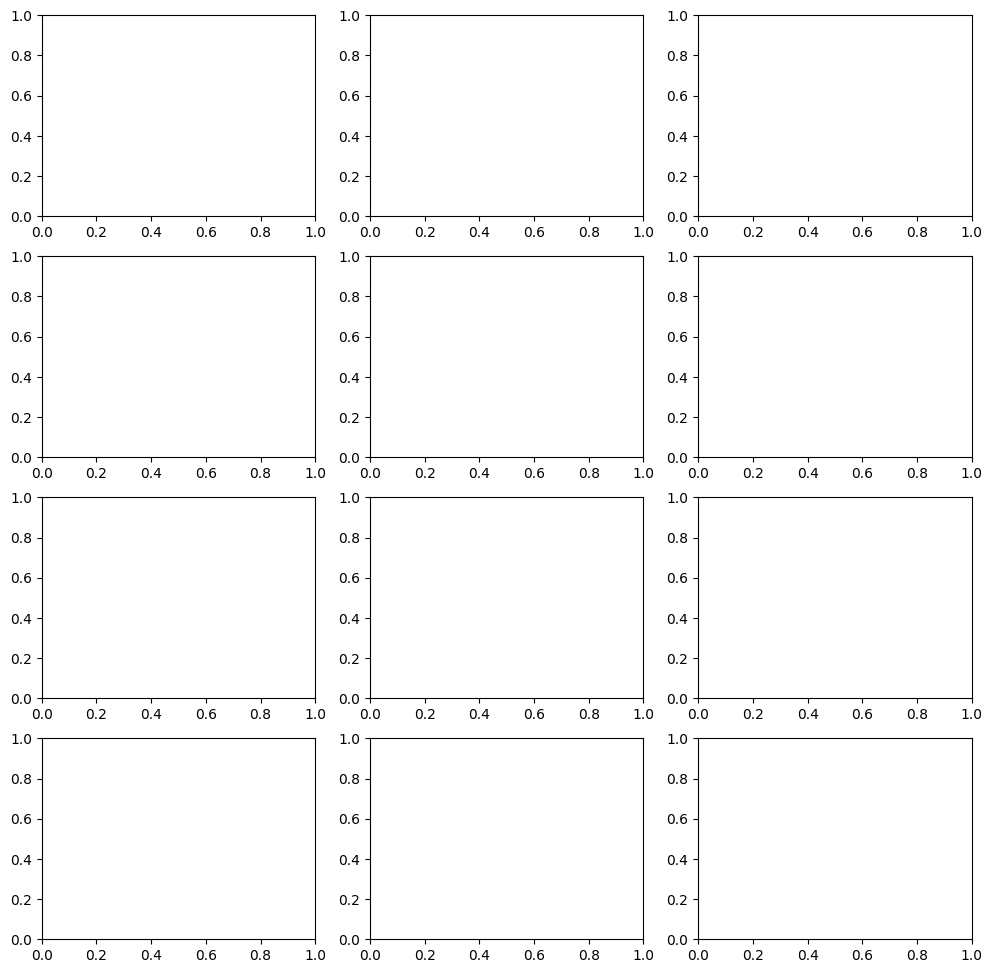

In [15]:
def visualize_samples(df, num_samples=4):
    """Visualize random samples from dataset"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*3))
    
    indices = np.random.choice(len(df), num_samples, replace=False)
    
    for idx, sample_idx in enumerate(indices):
        # Load image and mask
        image = cv2.imread(df.iloc[sample_idx]['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(df.iloc[sample_idx]['mask_path'], cv2.IMREAD_GRAYSCALE)
        
        # Original image
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title(f'Original Image {sample_idx}')
        axes[idx, 0].axis('off')
        
        # Mask
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title(f'Ground Truth Mask {sample_idx}')
        axes[idx, 1].axis('off')
        
        # Overlay
        overlay = image.copy()
        overlay[mask > 0] = [255, 0, 0]  # Red overlay on stones
        axes[idx, 2].imshow(overlay)
        axes[idx, 2].set_title(f'Overlay {sample_idx}')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/dataset_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Sample visualization saved!")

visualize_samples(data_df, num_samples=4)
print("="*50)